# **Importing Libraries**

In [1]:
import math
import pylab
import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
from scipy.stats.distributions import chi2
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Reading Data**

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Applied Time Series/SUNPHARMA.NSI.csv')

In [4]:
df = df[['Date','Close']]

In [5]:
df.head()

,Date,Close
0,2010-01-04,150.735001
1,2010-01-05,155.264999
2,2010-01-06,157.279999
3,2010-01-07,154.884995
4,2010-01-08,157.494995


In [6]:
df.shape

(3406, 2)

## Checking for missing values

In [7]:
df.isna().sum()

Date     0
Close    7
dtype: int64

In [8]:
nan_df = df[df['Close'].isna()]
nan_df

,Date,Close
24,2010-02-06,NaN
502,2012-01-07,NaN
541,2012-03-03,NaN
671,2012-09-08,NaN
713,2012-11-11,NaN
1050,2014-03-22,NaN
1279,2015-02-28,NaN


## Dropping rows with missing data because it was saturday

In [9]:
df = df.dropna()

In [10]:
df.isna().sum()

Date     0
Close    0
dtype: int64

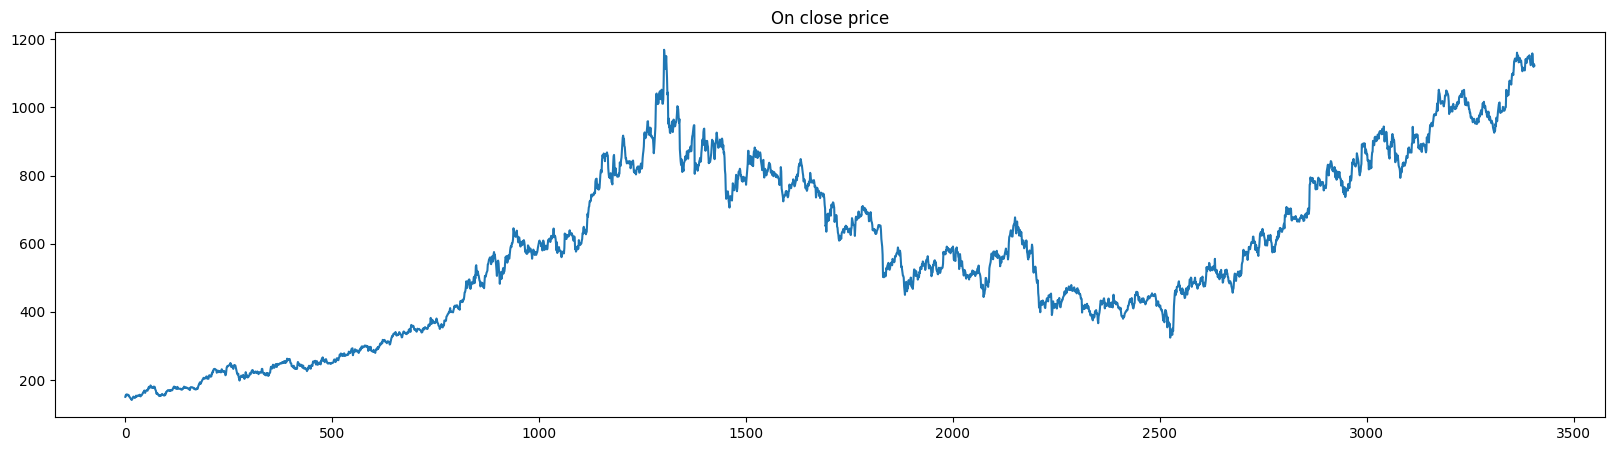

In [11]:
df['Close'].plot(figsize=(20,5), title = "On close price")
plt.show()

# **Q-Q Plot**


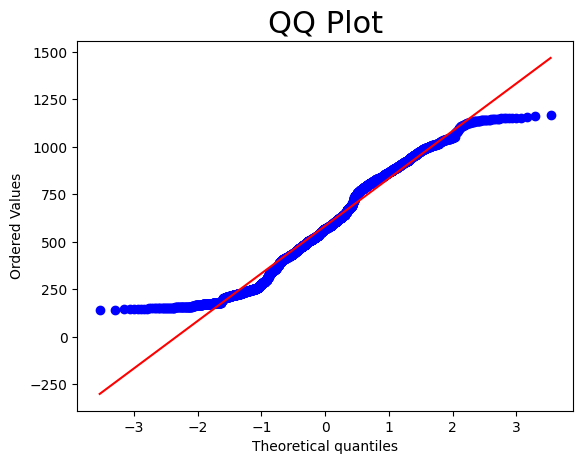

In [13]:
scipy.stats.probplot(df['Close'], plot = pylab)
plt.title("QQ Plot", size = 22)
pylab.show()

# **Transforming Data**

In [14]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date", inplace=True)

In [15]:
df.head()

,Close
Date,
2010-01-04,150.735001
2010-01-05,155.264999
2010-01-06,157.279999
2010-01-07,154.884995
2010-01-08,157.494995


# **Seasonal Decomposition on original data**

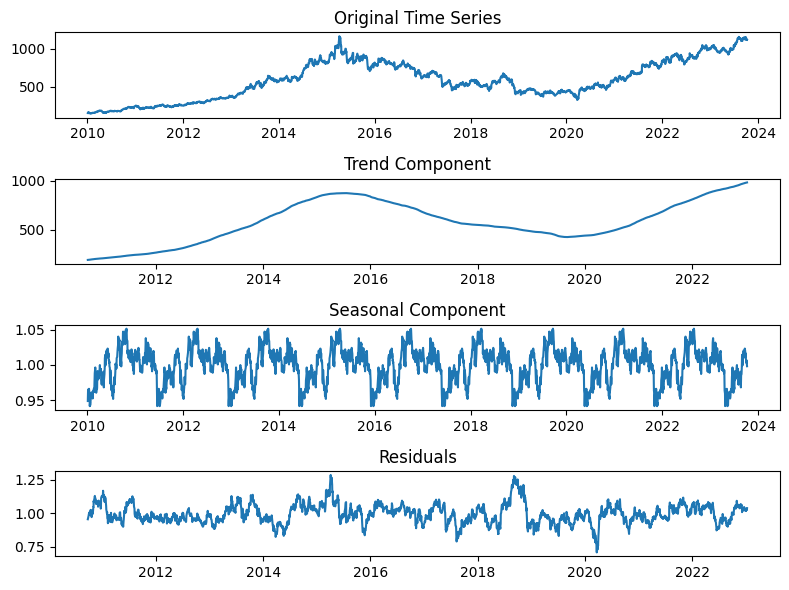

In [16]:
result = seasonal_decompose(df['Close'], model='multiplicative',  period=365)

plt.figure(figsize=(8, 6))
plt.subplot(411)
plt.plot(df['Close'], label='Original Time Series')
plt.title('Original Time Series')
plt.subplot(412)
plt.plot(result.trend, label='Trend Component')
plt.title('Trend Component')
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal Component')
plt.title('Seasonal Component')
plt.subplot(414)
plt.plot(result.resid, label='Residuals')
plt.title('Residuals')
plt.tight_layout()
plt.show()

# **Checking Stationarity on close price (original data)**

Since p-value (0.833696) is significantly greater than 0.05, we do not have enough evidence to reject the null hypothesis. Therefore, based on the ADF test results, it suggests that the time series is non-stationary.

In [17]:
result = sm.tsa.stattools.adfuller(df['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.735068
p-value: 0.837456
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


# **Making Data Stationay Using Following Techniques**

1. Normal Returns
2. Log Returns
3. Log
4. 1st order differencing
5. 2nd order differencing

Then we test which of the above method can be used for modelling by looking at ADF, ACF & PACF

In [18]:
df['normal_returns'] = df['Close'] / df['Close'].shift(1) - 1 # normal returns

df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1)) # log returns

df['log'] = np.log(df['Close'])

df['differencing'] = df['Close'].diff() # first order

df['second_Differencing'] = df['differencing'].diff() # second-order



In [19]:
df.head()

,Close,normal_returns,log_returns,log,differencing,second_Differencing
Date,,,,,,
2010-01-04,150.735001,NaN,NaN,5.015523,NaN,NaN
2010-01-05,155.264999,0.030053,0.029610,5.045133,4.529998,NaN
2010-01-06,157.279999,0.012978,0.012894,5.058028,2.015000,-2.514998
2010-01-07,154.884995,-0.015228,-0.015345,5.042683,-2.395004,-4.410004
2010-01-08,157.494995,0.016851,0.016711,5.059394,2.610000,5.005004


# **LLR Test**

In [20]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

# **Checking stationarity on Normal Returns**

p-value is less than 0.05 and ADF Statistic is also less than critical value (at 5%).

---

**Data is now stationary**

In [21]:
df['normal_returns'] = df['normal_returns'].fillna(0)

result = sm.tsa.stattools.adfuller(df['normal_returns'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -58.217536
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In Below ACF & PACF Plots we can't identify lags as none of the lags are above significant threshold.


---

**Can be a case of white noise.**


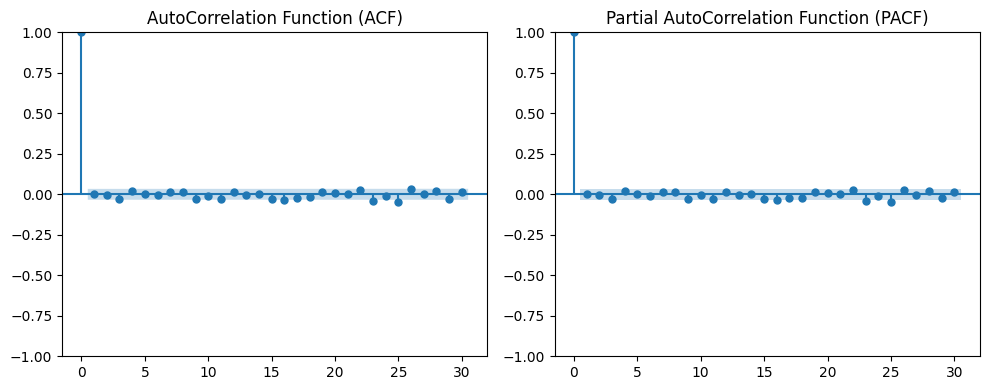

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

sgt.plot_acf(df['normal_returns'], lags=30, ax=ax1)
ax1.set_title('AutoCorrelation Function (ACF)')

sgt.plot_pacf(df['normal_returns'], lags=30, ax=ax2)
ax2.set_title('Partial AutoCorrelation Function (PACF)')

plt.tight_layout()

plt.show()

# **Checking stationarity on Log Returns**

p-value is less than 0.05 and ADF Statistic is also less than critical value (at 5%).


---


**Data is now stationary**



In [23]:
df['log_returns'] = df['log_returns'].fillna(0)

result = sm.tsa.stattools.adfuller(df['log_returns'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -58.284487
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Below results are quite similar to normal returns. We can't identify lags as none of the lags are above significant threshold.


---

**Can be a case of white noise.**


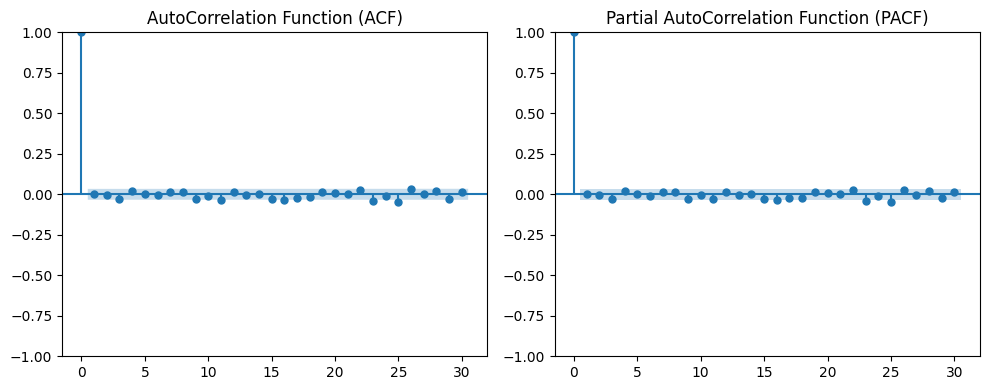

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

sgt.plot_acf(df['log_returns'], lags=30, ax=ax1)
ax1.set_title('AutoCorrelation Function (ACF)')

sgt.plot_pacf(df['log_returns'], lags=30, ax=ax2)
ax2.set_title('Partial AutoCorrelation Function (PACF)')

plt.tight_layout()

plt.show()

# **Checking stationarity on First Order Differencing**

p-value is less than 0.05 and ADF Statistic is also less than critical value (at 5%).


---


**Data is now stationary**



In [25]:
df['differencing'] = df['differencing'].fillna(0)

result = sm.tsa.stattools.adfuller(df['differencing'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.634190
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Results are quite similar to normal returns/differencing. We can't identify lags as none of the lags are above significant threshold.


---

**Can be a case of white noise.**


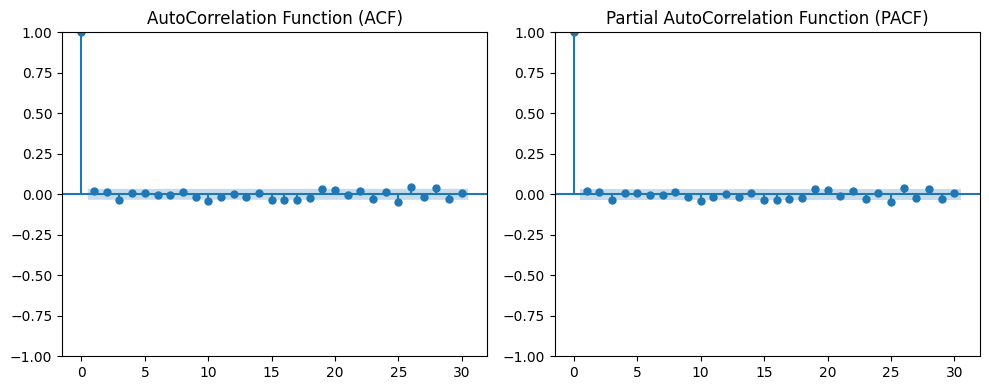

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

sgt.plot_acf(df['differencing'], lags=30, ax=ax1)
ax1.set_title('AutoCorrelation Function (ACF)')

sgt.plot_pacf(df['differencing'], lags=30, ax=ax2)
ax2.set_title('Partial AutoCorrelation Function (PACF)')

plt.tight_layout()

plt.show()

# **Checking stationarity on Second Order Differencing**
p-value is less than 0.05 and ADF Statistic is also less than critical value (at 5%).


---


**Data is now stationary**


In [27]:
df['second_Differencing'] = df['second_Differencing'].fillna(0)

result = sm.tsa.stattools.adfuller(df['second_Differencing'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.392412
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Based on below plots following points are observed


---

1. PACF is decaying exponentially
2. There's a sudden drop in ACF at lag 1

**Based on this we can try MA(1) model**



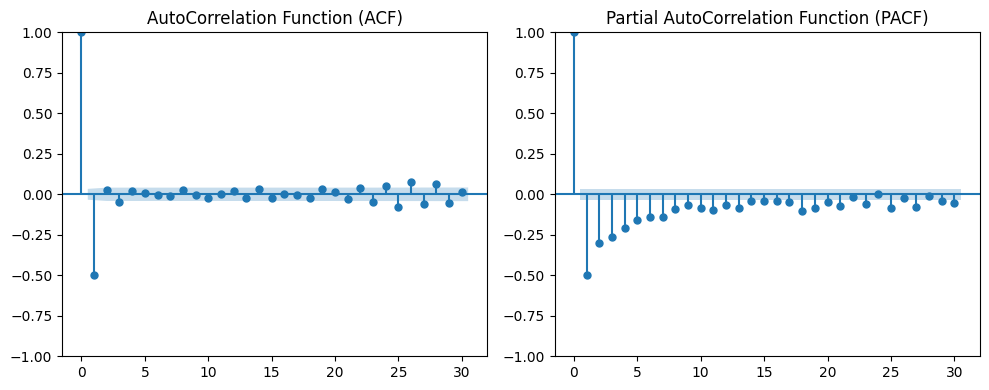

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

sgt.plot_acf(df['second_Differencing'], lags=30, ax=ax1)
ax1.set_title('AutoCorrelation Function (ACF)')

sgt.plot_pacf(df['second_Differencing'], lags=30, ax=ax2)
ax2.set_title('Partial AutoCorrelation Function (PACF)')

plt.tight_layout()

plt.show()

# **Modelling**

In [31]:
from statsmodels.tsa.arima.model import ARIMA

model_ma_1 = ARIMA(df['second_Differencing'], order=(0,2,1))
model_fit_ma1 = model_ma_1.fit()
print(model_fit_ma1.summary())

                                SARIMAX Results                                
Dep. Variable:     second_Differencing   No. Observations:                 3399
Model:                  ARIMA(0, 2, 1)   Log Likelihood              -16026.666
Date:                 Sun, 15 Oct 2023   AIC                          32057.333
Time:                         12:07:53   BIC                          32069.594
Sample:                              0   HQIC                         32061.715
                                - 3399                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9996      0.053    -18.729      0.000      -1.104      -0.895
sigma2       731.9498     39.778     18.401      0.000     653.986     809.914
Ljung-Box (L1) (Q):                1546.42  

# **Trying Higher Lags MA Models**

In [37]:
model_ma_2 = ARIMA(df['second_Differencing'], order=(0,2,2))
model_fit_ma2 = model_ma_2.fit()
print(model_fit_ma2.summary())

                                SARIMAX Results                                
Dep. Variable:     second_Differencing   No. Observations:                 3399
Model:                  ARIMA(0, 2, 2)   Log Likelihood              -14174.958
Date:                 Sun, 15 Oct 2023   AIC                          28355.916
Time:                         12:32:05   BIC                          28374.308
Sample:                              0   HQIC                         28362.490
                                - 3399                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9966      0.006   -318.419      0.000      -2.009      -1.984
ma.L2          0.9997      0.006    159.172      0.000       0.987       1.012
sigma2       245.1867      2.949     83.145 

In [38]:
model_ma_3 = ARIMA(df['second_Differencing'], order=(0,2,3))
model_fit_ma3 = model_ma_3.fit()
print(model_fit_ma3.summary())

                                SARIMAX Results                                
Dep. Variable:     second_Differencing   No. Observations:                 3399
Model:                  ARIMA(0, 2, 3)   Log Likelihood              -13092.521
Date:                 Sun, 15 Oct 2023   AIC                          26193.041
Time:                         12:32:09   BIC                          26217.564
Sample:                              0   HQIC                         26201.807
                                - 3399                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.9594      0.004   -659.713      0.000      -2.968      -2.951
ma.L2          2.9198      0.009    326.383      0.000       2.902       2.937
ma.L3         -0.9604      0.004   -215.007 

ACF & PACF plots were suggesting MA(1) model.

---

But when we tried MA(2) model, their AIC, BIC & Log Likelihood were less as compared to MA(1) model.

---
Similarly when we tried MA(3) model it showed less AIC, BIC & Log Likelihood compared to MA(2) model


In [39]:
print("LLR Test between MA(1) and MA(2)")
LLR_test(model_ma_1,model_ma_2)

LLR Test between MA(1) and MA(2)


0.0

In [40]:
print("LLR Test between MA(2) and MA(3)")
LLR_test(model_ma_2,model_ma_3)

LLR Test between MA(2) and MA(3)


0.0

In [41]:
print("LLR Test between MA(1) and MA(3)")
LLR_test(model_ma_1,model_ma_3)

LLR Test between MA(1) and MA(3)


0.0

The LLR test statistic is 0.0, which suggests that there is no significant difference in the goodness of fit between the MA(1) and MA(2) models.
In other words, the more complex MA(2) model does not provide a statistically significant improvement in explaining the data compared to the simpler MA(1) model. Same goes with MA(3)

In all cases, a LLR test statistic of 0.0 suggests that the simpler model is sufficient to explain the data.

# **Analyzing Residuals**

In [49]:
df['residuals'] = model_fit_ma1.resid

In [52]:
df['residuals'] = df['residuals'].fillna(0)

result = sm.tsa.stattools.adfuller(df['residuals'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -24.454909
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


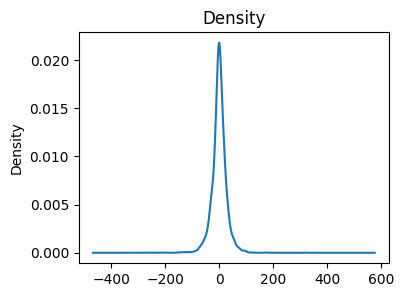

In [53]:
plt.figure(figsize=(4, 3))
df['residuals'].plot(kind='kde', title='Density')
plt.show()

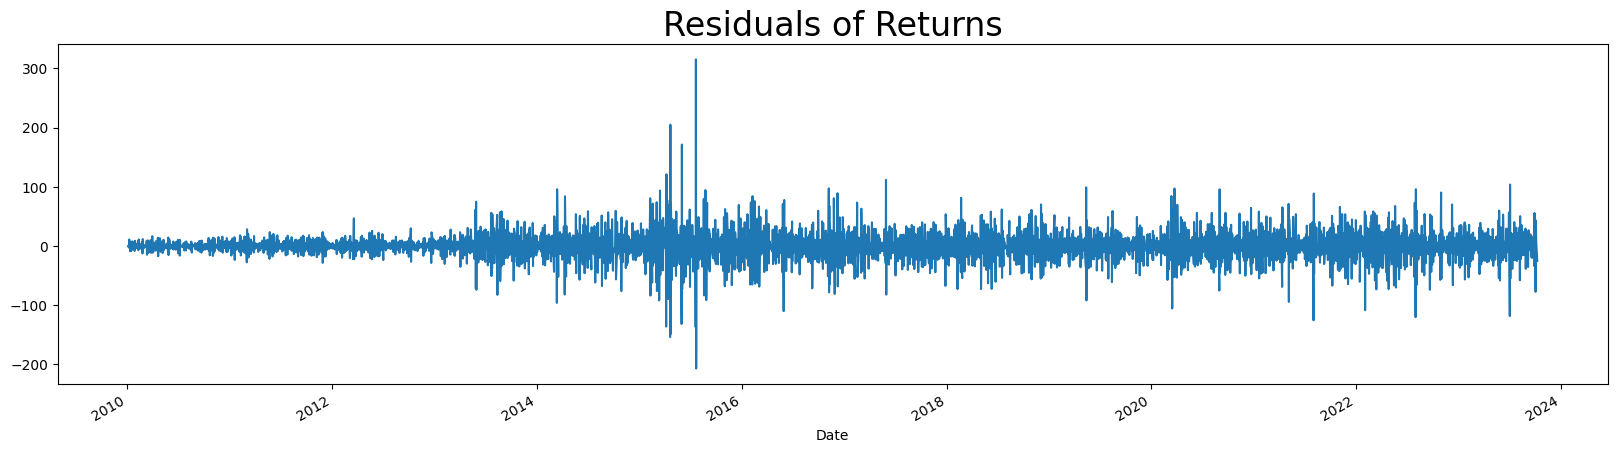

In [54]:
df['residuals'].plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()